# Latent Space Clustering and Generating

In [18]:
import numpy as np
import utils
from data import loader
import math
from model.rvae import RVAE
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
import matplotlib.pyplot as plt
from scipy import stats
% matplotlib widget

In [3]:
config = utils.read_cfg('../config/template-rvae.yaml')
train, test_scenarios = loader.load(config)
test = test_scenarios['ctu-1-2-9']

train_norm, train_bot = utils.split_mal_norm(train)
count_x = math.floor(train_norm.shape[0] / 5)
train_norm = utils.remove_ylabel(train_norm)
train_norm = utils.reshape_for_rnn(train_norm.values)

train_bot = utils.remove_ylabel(train_bot)
train_bot = utils.reshape_for_rnn(train_bot.values)

test_norm, test_bot = utils.split_mal_norm(test)
test_norm = utils.remove_ylabel(test_norm)
test_norm = utils.reshape_for_rnn(test_norm.values)
test_bot = utils.remove_ylabel(test_bot)
test_bot = utils.reshape_for_rnn(test_bot.values)

feature_dim = train_norm.shape

print('jo')

jo


In [9]:
config['model']['config']['latent-dimension'] = 2
model = utils.create_model(config, feature_dim=feature_dim)
model.fit(train_norm, epochs=500, batch_size=128)

Epoch 1/500
14/14 [==============================] - 4s 15ms/step - loss: 11.3243 - reconstruction_loss: 10.6583 - kl_loss: 0.0070 - z_mean: 0.0184 - z_log_var: 0.0031
Epoch 2/500
14/14 [==============================] - 0s 23ms/step - loss: 8.2779 - reconstruction_loss: 7.7909 - kl_loss: 0.0124 - z_mean: 0.0238 - z_log_var: -0.0026
Epoch 3/500
14/14 [==============================] - 0s 20ms/step - loss: 6.7096 - reconstruction_loss: 6.6201 - kl_loss: 0.0207 - z_mean: 0.0325 - z_log_var: -0.0124
Epoch 4/500
14/14 [==============================] - 0s 15ms/step - loss: 6.0874 - reconstruction_loss: 5.9735 - kl_loss: 0.0253 - z_mean: 0.0410 - z_log_var: -0.0238
Epoch 5/500
14/14 [==============================] - 0s 15ms/step - loss: 5.6096 - reconstruction_loss: 5.4292 - kl_loss: 0.0273 - z_mean: 0.0476 - z_log_var: -0.0343
Epoch 6/500
14/14 [==============================] - 0s 14ms/step - loss: 5.2136 - reconstruction_loss: 5.1243 - kl_loss: 0.0284 - z_mean: 0.0519 - z_log_var: -0.04

In [10]:
mu, log_sig, z = model.encoder.predict(train_norm)
nu_mal, log_sig_mal, z_mal = model.encoder.predict(train_bot)
err_normal_train, mu_normal_train, log_sig_normal_train = utils.pred(model, train_norm, axis=(1, 2))

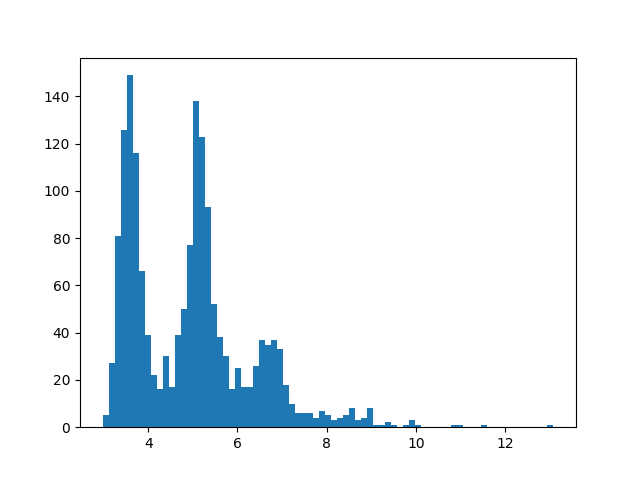

In [11]:
plt.figure()
plt.hist(err_normal_train, bins=75)
plt.show()

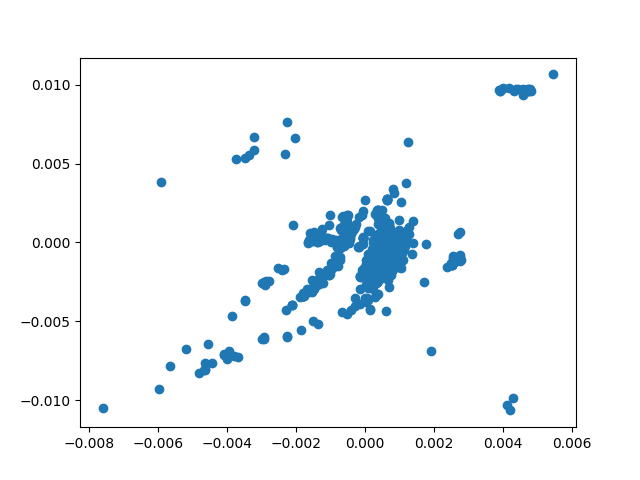

In [13]:
plt.figure()
plt.scatter(mu_normal_train[:, 0], mu_normal_train[:, 1])
plt.show()

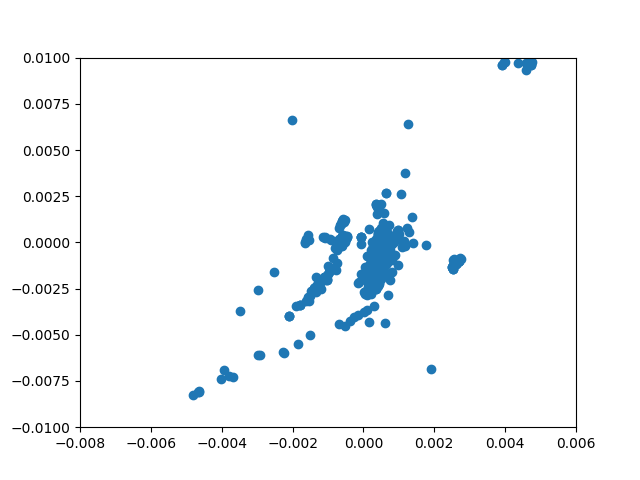

In [58]:
mu_normal_train_z = np.absolute(stats.zscore(mu_normal_train, axis=None))
err_normal_train_z = np.absolute(stats.zscore(err_normal_train, axis=None))
idx = (mu_normal_train_z > 1)
idx_err = (np.absolute(err_normal_train) > 4) & (np.absolute(err_normal_train) < 6)
# idx_err_ok = !idx_err
mu_interesting = mu_normal_train[idx_err]
# mu_others = mu_normal_train[idx_err_ok]
plt.figure()
# plt.scatter(mu_others[:,0], mu_others[:,1])
plt.scatter(mu_interesting[:,0], mu_interesting[:,1])
plt.xlim([-0.008, 0.006])
plt.ylim([-0.01,0.01])
plt.show()

Epoch 1/500
21/21 [==============================] - 3s 16ms/step - loss: -0.7722 - reconstruction_loss: -0.5954 - kl_loss: 1.1846e-04 - z_mean: 7.8741e-04 - z_log_var: -0.0024
Epoch 2/500
21/21 [==============================] - 0s 16ms/step - loss: -0.5957 - reconstruction_loss: -0.6277 - kl_loss: 3.9982e-04 - z_mean: -2.8930e-04 - z_log_var: -0.0083
Epoch 3/500
21/21 [==============================] - 0s 16ms/step - loss: -0.6499 - reconstruction_loss: -0.6602 - kl_loss: 8.5749e-04 - z_mean: -0.0015 - z_log_var: -0.0126
Epoch 4/500
21/21 [==============================] - 0s 17ms/step - loss: -0.5888 - reconstruction_loss: -0.5826 - kl_loss: 0.0011 - z_mean: -0.0026 - z_log_var: -0.0155
Epoch 5/500
21/21 [==============================] - 0s 17ms/step - loss: -0.6074 - reconstruction_loss: -0.6157 - kl_loss: 0.0011 - z_mean: -0.0032 - z_log_var: -0.0175
Epoch 6/500
21/21 [==============================] - 0s 17ms/step - loss: -0.7440 - reconstruction_loss: -0.6157 - kl_loss: 0.0013 

In [21]:
# fig = plt.figure(figsize=(20, 10))
# ax = fig.add_subplot(projection='3d')
# plt.scatter(z2[:, 0], z2[:, 1], color='green')
# plt.scatter(z_mal2[:, 0], z_mal2[:, 1], color='red')
# plt.show()

In [22]:
from downstream.kernel_density import KDEDownstream

x = np.concatenate([train_norm, train_bot])

err_1, _, _ = utils.pred(vae, x, axis=(1, 2))
err_2, _, _ = utils.pred(vae2, x, axis=(1, 2))
y = np.concatenate((np.zeros(train_norm.shape[0]), np.ones(train_bot.shape[0])), axis=None)

m1 = KDEDownstream()
m1.fit(err_1, y)

m2 = KDEDownstream()
m2.fit(err_2, y)

utils.simple_eval(test, vae, m1)
utils.simple_eval(test, vae2, m2)

#normal: 422 / #bot: 378
prec:0.883177570093458
rec:1.0
f1: 0.9379652605459057
[[372  50]
 [  0 378]]
#normal: 422 / #bot: 378
prec:0.8894117647058823
rec:1.0
f1: 0.9414694894146949
[[375  47]
 [  0 378]]
